In [ ]:
!pip install yfinance numpy pandas scikit-learn tensorflow keras-tuner scikit-optimize matplotlib

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, confusion_matrix, roc_curve, auc, roc_auc_score, RocCurveDisplay
from datetime import datetime, timedelta
from skopt import BayesSearchCV
from skopt.space import Real
import matplotlib.pyplot as plt

In [3]:
# download data
tickers = [
    "MQG.AX","ALL.AX", "ANZ.AX", "BHP.AX", "CBA.AX", "CSL.AX", "FMG.AX", 
    "GMG.AX", "NAB.AX", "REA.AX", "RIO.AX", "TCL.AX", 
    "TLS.AX", "WBC.AX", "WES.AX", "WOW.AX", "WDS.AX", "XRO.AX"
]

# Calculate the date 10 years ago from today, or use a fixed start date
start_date = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date for the end date

# Fetch the stock data and store in a list of DataFrames
stock_data = []
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date, interval='1wk')
    stock_data.append(df)
print(len(stock_data))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

18


In [4]:
# define target
for i in range(0,len(stock_data)):
    
# define target value (closing price of the next day)
    stock_data[i]['Target'] = stock_data[i]['Close'].shift(-1) # -1 used to used next day's price as target

In [5]:
# add indicators

for i in stock_data:
    data = i
    # SMA-10
    data['SMA_10'] = data['Close'].rolling(window=10).mean().shift(1)
    # SMA 25
    data['SMA_25'] = data['Close'].rolling(window=25).mean().shift(1)

    # Momentum (Close price difference shifted by 1 to use previous day's data)
    data['Momentum'] = data['Close'].diff().shift(1)

    # Stochastic %K and %D using data up to the previous day
    low_min = data['Low'].rolling(window=14).min().shift(1)
    high_max = data['High'].rolling(window=14).max().shift(1)
    data['Stochastic_%K'] = ((data['Close'].shift(1) - low_min) / (high_max - low_min)) * 100
    data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

    # RSI calculated from previous days
    delta = data['Close'].diff(1).shift(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD calculation shifted to include only past data
    exp1 = data['Close'].ewm(span=12, adjust=False).mean().shift(1)
    exp2 = data['Close'].ewm(span=26, adjust=False).mean().shift(1)
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    data['MACD'] = macd
    data['MACD_Signal'] = signal

    # list of columns
    columns = ['Open', 'High', 'Low', 'Close', 'Volume',
               'Target', 'SMA_10', 'SMA_25', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI',
               'MACD', 'MACD_Signal']

    # reorder columns to put 'Target' in the end
    columns.remove('Target')
    columns.append('Target')

    data= data[columns]
        

In [6]:
# Drop all rows that contain any NaN values
for i in range(len(stock_data)):
    stock_data[i].dropna(inplace=True)

In [7]:
scaled_features = [] 
scaled_targets = []  

# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Loop through each DataFrame
for df in stock_data:
    # Assume the last column is the target, the rest are features
    if not df.empty and df.shape[1] > 1:  # Ensure DataFrame has more than one column
        scaled_data = scaler.fit_transform(df.values)  # Scale the data

        # Split scaled data into features and target
        features = scaled_data[:, :-1]
        target = scaled_data[:, -1]

        # Store the scaled features and targets in their respective lists
        scaled_features.append(features)
        scaled_targets.append(target)

In [9]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []


# Split each dataset
for features, target in zip(scaled_features, scaled_targets):
    split_idx = int(len(features) * 0.7)  # 70% for training
    X_train_list.append(features[:split_idx])
    X_test_list.append(features[split_idx:])
    y_train_list.append(target[:split_idx])
    y_test_list.append(target[split_idx:])
    
# for i, (feat, targ) in enumerate(zip(scaled_features, scaled_targets)):
#     print(f"Features shape for DataFrame {i}: {feat.shape}")
#     print(f"Target shape for DataFrame {i}: {targ.shape}")

In [12]:
search_spaces = {
    'C': Real(0.1, 1000, prior='log-uniform'),
    'epsilon': Real(0.1, 2, prior='log-uniform')
}

# Perform Bayesian Optimization
svm_regressor = SVR(kernel='linear')

bayes_search = BayesSearchCV(estimator=svm_regressor, search_spaces=search_spaces, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


for X_train, y_train in zip(X_train_list, y_train_list):
    bayes_search.fit(X_train, y_train)

model = bayes_search.best_estimator_


In [17]:
predictions = model.predict(X_test_list[0]) # MQG.AX stock

# evaluation
y_pred = predictions
y_test = y_test_list[0] # MQG.AX stock



explained_variance = explained_variance_score(y_test, predictions)
print("Explained Variance Score:", explained_variance)


# Mean Squared Error (MSE)
mse = MeanSquaredError()
mse.update_state(y_test, y_pred)
mse_result = mse.result().numpy()
print("Mean Squared Error (MSE):", mse_result)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_result)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = MeanAbsoluteError()
mae.update_state(y_test, y_pred)
mae_result = mae.result().numpy()
print("Mean Absolute Error (MAE):", mae_result)

# r^2
r2 = r2_score(y_test, y_pred)
print("R^2 (Coefficient of Determination):", r2)

# Calculate Mean Bias Deviation (MBD)
def mean_bias_deviation(y_true, y_pred):
    differences = y_true - y_pred
    mbd = np.mean(differences)
    return mbd

# Calculate MBD for the test set
mbd = mean_bias_deviation(y_test, y_pred)
print("Mean Bias Deviation:", mbd)

Explained Variance Score: 0.5920628113131188
Mean Squared Error (MSE): 0.05926636
Root Mean Squared Error (RMSE): 0.24344683
Mean Absolute Error (MAE): 0.21343385
R^2 (Coefficient of Determination): -0.18145681397454783
Mean Bias Deviation: -0.19698396319226222


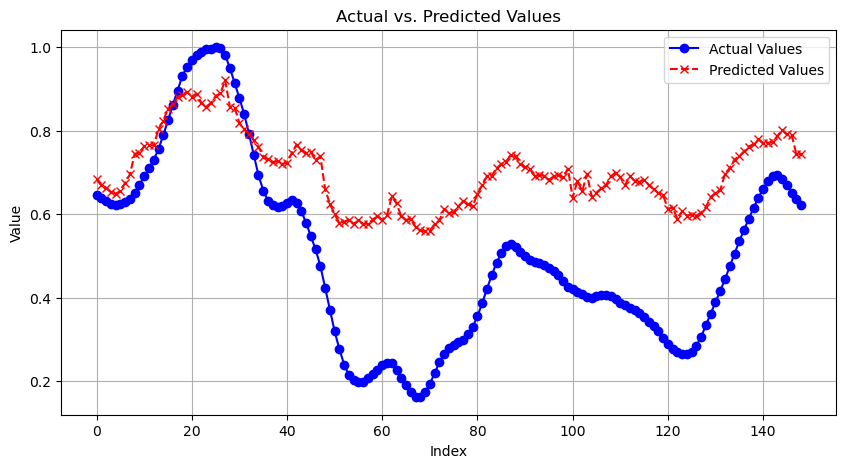

In [18]:
# plot results for macquarie group stock
y_test = np.array(y_test)
predictions = np.array(predictions)

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.plot(range(len(predictions)), predictions, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
